In [155]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = '0'

In [156]:
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import json
from tqdm import tqdm
from collections import Counter
import matplotlib.pyplot as plt

In [157]:
from models.detector import Detector
from models.place_classifier import PlaceClassifier
from models.features_extractor import FeatureExtractor

In [158]:
from utils.dataset_parser import DatasetParser

In [159]:
from transformers import DistilBertModel, DistilBertConfig
from transformers import DistilBertTokenizer, DistilBertModel

In [160]:
classifier = PlaceClassifier()

In [161]:
detector = Detector()

INFO:absl:Using /tmp/tfhub_modules to cache modules.


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


In [162]:
configuration = DistilBertConfig()

In [163]:
model_nlp = DistilBertModel(configuration)

In [164]:
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')

In [165]:
data_parser = DatasetParser('dataset')

In [166]:
def get_embedding(inputs):
    inputs = tokenizer(inputs, return_tensors="pt")
    outputs = model_nlp(**inputs)
    embeddings = outputs.last_hidden_state[:, -1].mean(axis = 0).detach().numpy()
    return embeddings

In [167]:
def get_objects_embedding(objects):
    obj_embeddings = []
    for obj in objects:
         obj_embeddings.append(get_embedding(obj))
    if len(obj_embeddings) == 0:
        return []
    else:
        mean_obj_emb = np.mean(obj_embeddings, axis = 0)
    return mean_obj_emb

In [168]:
def get_places_embedding(places_dict):
    places = places_dict.keys()
    places_emb = []
    for place in places:
        place = place.split('/')[0].replace('_', ' ')
        place_emb = get_embedding(place)
        places_emb.append(place_emb)
    if len(place_emb) == 0:
        return []
    mean_places_emb = np.mean(places_emb, axis = 0)
    return mean_places_emb

In [169]:
def get_pic_embeddings(img_path, model):
    image = tf.image.decode_png(tf.io.read_file(img_path))
    image = tf.image.resize(image, (224, 224))
    image = tf.expand_dims(image, axis = 0)
    result = model(image)
    return result

In [170]:
image_features_extractor = FeatureExtractor()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
efficientnetb3 (Functional)  (None, None, None, 1536)  10783535  
_________________________________________________________________
global_average_pooling2d_1 ( (None, 1536)              0         
_________________________________________________________________
normalization_3 (Normalizati (None, 1536)              3073      
Total params: 10,786,608
Trainable params: 0
Non-trainable params: 10,786,608
_________________________________________________________________


In [172]:
# imgs_embeddings = []
imgs_tags = []
imgs_pic_embeddings = []
imgs_paths = []

for img_path, tags in tqdm(zip(data_parser.imgs_paths, data_parser.tags)):
    try:
        img = Image.open(img_path)
        imgs_paths.append(img_path)
        imgs_tags.append(tags)
    #     places_dict, _ = classifier.predict(np.array(img))
    #     objects = detector.get_objects_on_img(img, min_score = 0.2)
        pic_embeddings = image_features_extractor.get_features(img)
        imgs_pic_embeddings.append(pic_embeddings)
    #     if (len(objects) == 0) or len(places_dict) == 0:
    #         continue
    #     obj_emb = get_objects_embedding(objects)
    #     places_emb = get_places_embedding(places_dict)
    #     embedding = np.mean([obj_emb, places_emb], axis = 0)
    #     embedding = obj_emb
    #     imgs_embeddings.append(embedding)
        img.close()
    except Exception as e:
        continue

51404it [3:02:30,  4.69it/s]


In [194]:
import pandas as pd
tags_df = pd.DataFrame(columns = ['tags'])
for idx, el in enumerate(imgs_tags):
    series = pd.Series({'tags' : el}, name = idx)
    tags_df = tags_df.append(series)

In [196]:
tags_df.to_csv('tags.csv')

In [174]:
imgs_embeddings_array = np.array(imgs_embeddings)

NameError: name 'imgs_embeddings' is not defined

In [175]:
pic_embeddings_array = np.array(imgs_pic_embeddings).reshape(-1, 1536)

In [176]:
pic_embeddings_array.shape

(41784, 1536)

In [177]:
from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import DBSCAN, AffinityPropagation

In [178]:
# knn_words = NearestNeighbors()
knn_pic = NearestNeighbors(n_neighbors=5)

In [179]:
# knn_words.fit(imgs_embeddings_array)
knn_pic.fit(pic_embeddings_array)

NearestNeighbors()

In [185]:
from joblib import dump, load

In [203]:
dump(knn_pic, 'image_features_knn.joblib') 

['image_features_knn.joblib']

In [180]:
def print_idx_tags(id_list, tags, imgs_paths, plot_images : bool = True):
    for id_ in id_list:
        print(f"Tags: {tags[id_]}")
        if plot_images:
            try:
                img = Image.open(imgs_paths[id_])
                plt.imshow(img)
                plt.show()
                img.close()
            except Exception as e:
                print(e)

In [181]:
def filter_by_distance(imgs_ids, distances, tresh_distance = 15.0):
    result_ids = []
    for id_, distance in zip(imgs_ids, distances):
        if distance <= tresh_distance:
            result_ids.append(id_)
    return result_ids

In [197]:
from models.closest_pictures_model import ClosestPicturesModel

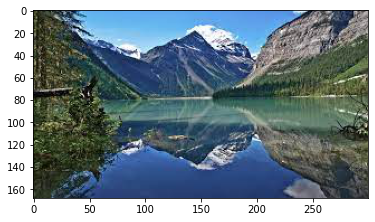

[['#aiguestortes', '#pirineus', '#catalunya', '#pnaiguestortes']]


In [200]:
test_img_path = "/home/aleks/image-tagging/Tests/test_images/test.jpg"
target_img = Image.open(test_img_path)
plt.imshow(target_img)
plt.show()
example_pic = image_features_extractor.get_features(target_img).reshape(1, -1)
target_img.close()

# example_word = imgs_embeddings[idx : idx + 1]
# example_pic = imgs_pic_embeddings[idx].reshape(1, -1)
closest_model = ClosestPicturesModel()
model_tags = closest_model.predict(example_pic)
print(model_tags)

# results_word = knn_words.kneighbors(example_word, return_distance = False)
distanses, results_pic = knn_pic.kneighbors(example_pic, return_distance = True)
distanses = distanses[0]
results_pic = results_pic[0]
results_pic = filter_by_distance(results_pic, distanses,tresh_distance = 50)
real_tags = imgs_tags[idx]
# print(f"Real tags: {real_tags}")
# print_idx_tags(results_pic, imgs_tags, imgs_paths)

In [201]:
def get_hashtags(tags_list, n_similar_tags = 2):
    counters = Counter(tags_list)
    result = []
    for tag, counter in counters.items():
        if counter >= n_similar_tags:
            result.append(tag)
    return result

In [202]:
predicted_tags = [el for i in results_pic for el in imgs_tags[i]]
get_hashtags(predicted_tags, n_similar_tags=2)

['#aiguestortes', '#pirineus', '#catalunya', '#pnaiguestortes']